<a href="https://colab.research.google.com/github/yeaeunJi/deep_learning-/blob/main/pytorch_example_with_explaination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설정관련 Code

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/dev_match/test.zip .
! cp /content/drive/MyDrive/dev_match/train.zip .
! cp /content/drive/MyDrive/dev_match/test_answer_sample_.csv .
! unzip test.zip
! unzip train.zip
! mkdir output

In [ ]:
! pip install opencv-python
! pip install ipywidgets
! pip install adamp
! pip install wandb
! pip install transformers
! pip install timm
! pip install albumentations
! pip install pillow

In [ ]:
import os
import glob
import random
import math
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import cv2 # 파이썬에서 대표적으로 활용하는 컴퓨터 비전, 이미지 관련 라이브러리
           # 이미지 읽기와 다양한 변환 기능 등을 제공
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
import albumentations as A
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from adamp import AdamP
import timm
import wandb
import matplotlib.pyplot as plt
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# Data 관련 Code

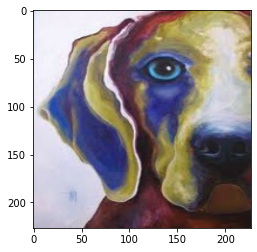

In [ ]:
# 이미지 샘플 확인
img = cv2.imread(img_paths[0])
plt.imshow(img)

In [ ]:
# 디렉토리 구조에 따라서 이미지 별 라벨링하는 함수
def labeling(img_paths) :
    classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
    img_labels = []
    for img_path in img_paths :
        for idx, c in enumerate(classes) :
            if c in img_path :
                img_labels.append(idx)
                break
                
    return img_labels

In [ ]:
# 전체 이미지의 Path를 받아오는 Code
path = Path('train')
img_paths = sorted([str(x) for x in list(path.glob('*/*'))])
img_labels = labeling(img_paths)

In [ ]:
# 전체 이미지의 갯수 확인
len(img_paths)

1698

In [ ]:
# train과 validation 구분 -> train 1000개, valid 698개
train_img_paths = img_paths[:1000]
train_img_labels = img_labels[:1000]
valid_img_paths = img_paths[1000:]
valid_img_labels = img_labels[1000:]

In [ ]:
# 이미지 샘플 shape과 type 확인 -> numpy array이며, 가로x세로x채널의 형태로 구성되어 있음.
print(img.shape)
print(type(img))

(227, 227, 3)
<class 'numpy.ndarray'>


In [ ]:
'''필수 구현'''
# Dataset class 구현
# torch.util.data.Dataset 을 반드시 상속 받아야 함.
# __init__, __len__, __getitem__을 반드시 구현해야 함.
# __len__은 데이터 셋의 길이를 return 하도록 설계해야 함.
# __getitem__은 index를 입력받아야하며, index에 해당하는 data를 return 하도록 설계해야 함.
class MyDataset(Dataset):
    def __init__(self, img_paths, img_labels=None):
        self.img_paths = img_paths
        self.img_labels = img_labels

    def __len__(self):
        return len(self.img_paths)

    # 자동적으로 아이템을 하나씩 뽑아오는 역할을 수행하는 메서드
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = self._to_tensor(img)
        label = None
        if self.img_labels:
            label = self.img_labels[idx]
        return {'image':img, 'label':label}
    
    def _to_tensor(self, img):
        img = img/255                 # 하나 하나의 픽셀 값이 1 ~ 255로 존재하므로 이 값을 0 ~ 1 사이의 값으로 변환
                                      # 본래 정규화 과정은 "평균과 분산을 구해 값을 나눠주고 빼서 진행 또는 
                                      # transform을 묶어서 처리하는 개체도 제공해주므로 필요하면 찾아서 공부하면 됨"
        img = img.transpose((2,0,1))  # 채널 축을 앞으로 보내기 위해 numpy의 transpose()를 활용
        # numpy : 가로 * 세로 * 채널 형태로 이미지를 저장
        # tensor : 채널 * 가로 * 세로 형태로 이미지를 저장

        img = torch.FloatTensor(img) # 기존 numpy를 tensor로 변환하고 내부 데이터도 float 형으로 변환
        return img

In [ ]:
# 구현한 MyDataset class의 인스턴스 및 Dataloader 생성
train_dataset = MyDataset(train_img_paths, train_img_labels)
valid_dataset = MyDataset(valid_img_paths, valid_img_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# Model 관련 Code

In [ ]:
'''필수 구현'''
# 사용할 Model을 설계하고 구현함.
# __init__, forward를 반드시 구현해야 함.
# Pretrained Model을 사용하고자 한다면, timm, torchvision과 같은 library 활용 가능
# forward는 data를 입력받을 수 있는 형태로 구현하고, 해당 data가 연산될 수 있는 구조를 설계해야 함.
class MyModel(nn.Module) :
    def __init__(self, model_name='tf_efficientnet_b3_ns', n_classes=7, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=n_classes)
    
    def forward(self, x) : 
        x = self.model(x)
        x = F.softmax(x, dim=-1) # 활성화 함수
        return x

In [ ]:
# 구현한 model 객체 생성
model = MyModel()

In [ ]:
# 사용할 device 정의
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device : {device}')
print(torch.cuda.get_device_properties(device))

device : cuda:0
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [ ]:
# model 객체를 해당 device로 보냄
model.to(device)

MyModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_runnin

# Train 관련 Code

In [ ]:
# loss function 정의
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# optimizer 정의
optimizer = AdamP(model.parameters(), lr=0.0001)

In [ ]:
# training step을 함수로 정의
def training(batch, model, loss_fn, optimizer, scheduler=None) :
    imgs = batch['image'].float().to(device) # 위에서 모델 객체를 해당 device(cpu or gpu)로 보냈기 때문에 같은 곳에서 연산이 이루어지도록 보내주어야 함
    labels = batch['label'].to(device)       # 위와 동일한 이유로 device로 옮김
    
    model.train()
    pred = model(imgs)
    loss = loss_fn(pred, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    pred = torch.argmax(pred, dim=1) # 분류이므로 가장 높은 확률을 가지는 클래스를 선택
    acc = accuracy_score(labels.cpu(), pred.cpu()) # cpu로 계산을 가져와 연산 수행
    
    return loss, acc

In [ ]:
# validating step을 함수로 정의
def validating(batch, model, loss_fn) :
    imgs = batch['image'].float().to(device)
    labels = batch['label'].to(device)
    
    model.eval()
    with torch.no_grad() : # 최적화가 필요없으므로 기록하지 않음
        pred = model(imgs)
        loss = loss_fn(pred, labels)
    
    pred = torch.argmax(pred, dim=1)
    acc = accuracy_score(labels.cpu(), pred.cpu())
    
    return loss, acc

In [ ]:
# Loss와 Metric을 핸들링 하기 위한 객체 선언
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# 실제 학습이 돌아가는 main code
best_acc = 0
for epoch in range(10):
    train_loss, train_acc = AverageMeter(), AverageMeter()
    with tqdm(train_loader,
              total=train_loader.__len__(),
              unit='batch') as train_bar:
              for batch in train_bar:
                  train_bar.set_description(f'Epoch{epoch+1}')

                  loss, acc = training(batch, model, loss_fn, optimizer)

                  train_loss.update(loss.item(), len(batch))
                  train_acc.update(acc, len(batch))
                  train_bar.set_postfix(train_acc=train_acc.avg, train_loss=train_loss.avg)
    
    valid_loss, valid_acc = AverageMeter(), AverageMeter()
    with tqdm(valid_loader,
              total=valid_loader.__len__(),
              unit='batch') as valid_bar:
              for batch in valid_bar:
                  valid_bar.set_description(f'Epoch{epoch+1}')

                  loss, acc = validating(batch, model, loss_fn)
                  
                  valid_loss.update(loss.item(), len(batch))
                  valid_acc.update(acc, len(batch))
                  valid_bar.set_postfix(valid_acc=valid_acc.avg, valid_loss=valid_loss.avg)